# GAN Generative Adversarial Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf 

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [2]:
# берем только семерки и подгоняем размер батча так, чтобы он делился без остатка на кол-во элементов в выборке
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[y_train ==7]
y_train = y_train[y_train ==7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100
BUFFER_SIZE = BUFFER_SIZE//BATCH_SIZE*BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print (x_train.shape, y_train.shape)

#стандартизация
x_train = x_train/255
x_test = x_test/255

x_train = np.reshape(x_train, (len(x_train),28,28,1))
x_test = np.reshape(x_test, (len(x_test),28,28,1))

#Перемешанный набор батчей
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(6200, 28, 28) (6200,)


In [3]:
hidden_dim = 2 # входной слой (размер)
def dropout_and_batch():
    return Dropout(0.3)(BatchNormalization())

#### Формируем сеть - ГЕНЕРАТОР

In [4]:
generator = tf.keras.Sequential([
    Dense (7*7*256, activation ='relu', input_shape =(hidden_dim,)),
    BatchNormalization(),
    Reshape((7,7,256)),
    Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', activation = 'relu'), # карта признаков 7х7 --> 14x14
    BatchNormalization(),
    Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', activation = 'sigmoid'), # карта признаков 14x14 --> 28x28
])
#generator.summary()

#### Формируем сеть - ДИСКРИМИНАТОР

In [5]:
discriminator = tf.keras.Sequential()

In [6]:
discriminator.add(Conv2D(64,(5,5), strides =(2,2), padding = 'same', input_shape= [28,28,1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

#### Потери

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#### Описание обучения

In [8]:
# для одного батча
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,hidden_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training = True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [9]:
def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)
    
    for epoch in range (1, epochs+1):
        print (f'{epoch}/{epochs}: ', end ='')
        start = time.time
        n=0 
        
        gen_loss_epoch = 0 
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n%th ==0): print('=', end ='=')
            n+=1
        history += [gen_loss_epoch/n]
        print(': '+str(history[-1]))
        #print('Время эпохи {} составляет {} секунд'.format(epoch,time.time() - start))
    return history

#### Запуск обучения

In [16]:
EPOCHS = 20
history = train (train_dataset, EPOCHS)

1/20: ======================: tf.Tensor(3.2193036, shape=(), dtype=float32)
2/20: ======================: tf.Tensor(3.0249307, shape=(), dtype=float32)
3/20: ======================: tf.Tensor(2.3426802, shape=(), dtype=float32)
4/20: ======================: tf.Tensor(1.6735193, shape=(), dtype=float32)
5/20: ======================: tf.Tensor(1.430683, shape=(), dtype=float32)
6/20: ======================: tf.Tensor(1.4382434, shape=(), dtype=float32)
7/20: ======================: tf.Tensor(1.3972467, shape=(), dtype=float32)
8/20: ======================: tf.Tensor(1.2461541, shape=(), dtype=float32)
9/20: ======================: tf.Tensor(1.0817678, shape=(), dtype=float32)
10/20: ======================: tf.Tensor(1.0503877, shape=(), dtype=float32)
11/20: ======================: tf.Tensor(1.0345978, shape=(), dtype=float32)
12/20: ======================: tf.Tensor(1.1705528, shape=(), dtype=float32)
13/20: ======================: tf.Tensor(1.0909307, shape=(), dtype=float32)
14/20: ==

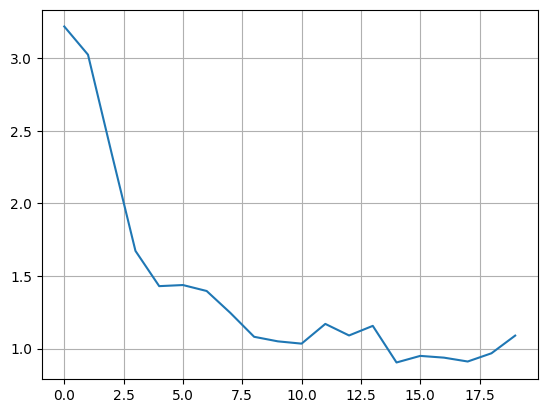

In [17]:
plt.plot(history)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 49ms/step


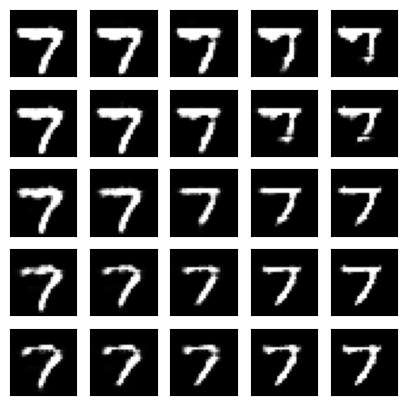

In [18]:
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(img[0, :, :, 0], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()